# Boundary segmentataion with topological modification of stallite Images 

### Ref: 
1. Delineation of Agricultural Field Boundaries from Sentinel-2 Images Using a   Novel Super-ResolutionContour Detector Based on FullyConvolutional   Networks (https://www.mdpi.com/2072-4292/12/1/59)


2. Topological image modification
for object detection and topological
image processing of skin lesions (https://doi.org/10.1038/S41598-020-77933-Y)

3. Topology-Preserving Deep Image Segmentation  (https://arxiv.org/abs/1906.05404)

## Overview Idea:

Looking at an image, deep inside it has geometrical structures, like closed paths, links, etc. In particular, for remote-sensing images, we mostly have closed path shapes, like (squares, rectangles circles etc). Similarly, the boundaries of farm fields are important features crucial for defining the shape, location, and spatial extent of farming units. Detecting these boundaries is challenging since, even from high-resolution images for example in the Senital dataset or  World-view, or any other these boundaries are not visible. 

Ref:  https://www.sciencedirect.com/science/article/pii/S003442571930272X

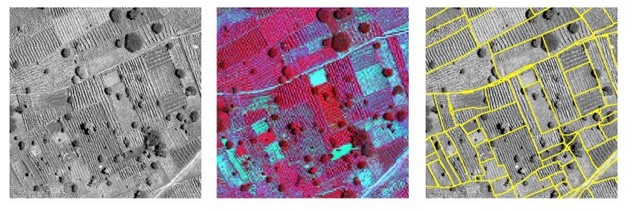

Since there is high probability that there are some broken boundaries/ or missing handles or something. I have used Topological Image Modification (TIM) and Topological Image Processing (TIP) for construct new objects with known topological properties (shapes, and edges) in irrelevant regions of an image, introduced in (https://doi.org/10.1038/S41598-020-77933-Y), the author has also published the code in paper, but that was used in different way

Persistant Homology (PH), is an important tool of TDA (Topological Data Analysis), which can detect the global structures of the considered image, and filters out irrelivant features, see..(https://arxiv.org/abs/1906.05404). For, example if we take an image or point cloud data, the aim of PH is to study the persistance of structures oin the image, on changing say radius of each data point, see the below figure:

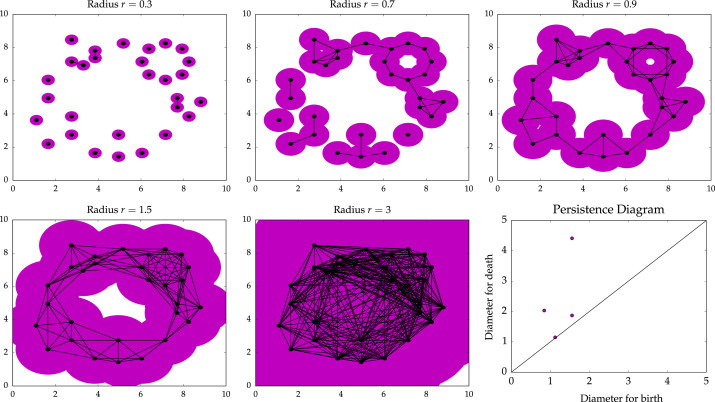

From the above figure, we can concolude that the data point are sampled from a circle, so the circluar shape is the global structure in thts image. So, studying the changes in the filterations on changing the radius, reveals that the global structute is cbig circle, also the smaller circles that appear for ($r < 1$) is the noise (irrelivant) 

In this code expository, we have used the Persistance Homology for modifying the input images for segmentation from(https://doi.org/10.1038/S41598-020-77933-Y). 

# This paper has used (https://www.mdpi.com/2072-4292/12/1/59) multiple dilation fully convolutional network (MD-FCN)for for agriculture field boundary detection from Sentinel-2 images at 10 m resolution.
 

# First I tried to use the same dataset on colab, but unfortunately I was not successful in dealing with the huge dataset, due to less computational resources and also the time for project was really modicum 

### **Then I used the dataset from this paper with same idea of segmenting the boundaries in cells (https://arxiv.org/abs/1906.05404)** and used the popular UNET model for boundary segmentation

## OUR RESULTS 

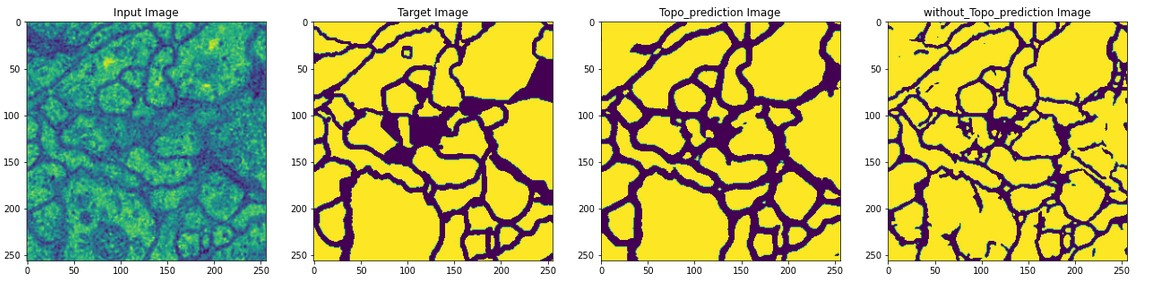

We can conclude that our results are comparable better

# CODE

#dataset

In [2]:
!pip install ripser

     |████████████████████████████████| 71kB 8.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 5.6MB/s 
  Created wheel for ripser: filename=ripser-0.6.0-cp37-cp37m-linux_x86_64.whl size=454908 sha256=499f682f2a00a1f70417084a9d09623684b1b47466e124d080627928049d7c66
  Stored in directory: /root/.cache/pip/wheels/95/1e/13/59da989de59903698d767dcb19414163e683a2dd31edf80417
Successfully built ripser
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18091 sha256=1533a71ece371398ae14475fc6dab12004e65a99528035a4221f7656d847d8d9
  Stored in directory: /root/.cache/pip/wheels/2b/e1/c9/1993c7f7f114b7d3fb2d3e895e02157a7ebf554861e9e54e01
Successfully built hopcroftkarp


In [3]:
!gdown --id 1d39lB8H4cp67PCMhDfuS6X8Btw7IPsiI

Downloading...
From: https://drive.google.com/uc?id=1d39lB8H4cp67PCMhDfuS6X8Btw7IPsiI
To: /content/Celldataset.zip
14.9MB [00:00, 41.0MB/s]


In [4]:
!unzip Celldataset.zip

Archive:  Celldataset.zip
   creating: Celldataset/
   creating: Celldataset/test/
  inflating: Celldataset/test/0.tif  
  inflating: Celldataset/test/1.tif  
  inflating: Celldataset/test/10.tif  
  inflating: Celldataset/test/11.tif  
  inflating: Celldataset/test/12.tif  
  inflating: Celldataset/test/13.tif  
  inflating: Celldataset/test/14.tif  
  inflating: Celldataset/test/15.tif  
  inflating: Celldataset/test/16.tif  
  inflating: Celldataset/test/17.tif  
  inflating: Celldataset/test/18.tif  
  inflating: Celldataset/test/19.tif  
  inflating: Celldataset/test/2.tif  
  inflating: Celldataset/test/20.tif  
  inflating: Celldataset/test/21.tif  
  inflating: Celldataset/test/22.tif  
  inflating: Celldataset/test/23.tif  
  inflating: Celldataset/test/24.tif  
  inflating: Celldataset/test/25.tif  
  inflating: Celldataset/test/26.tif  
  inflating: Celldataset/test/27.tif  
  inflating: Celldataset/test/28.tif  
  inflating: Celldataset/test/29.tif  
  inflating: Celldatase

In [5]:
!rm Celldataset.zip


In [6]:
mkdir model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        x = self.conv(a)
        return x


class UNet(nn.Module):
    def __init__(self, in_chs= 1, dimensions=2):
        super(UNet, self).__init__()
        self.conv1 = double_conv(in_chs, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.down3 = down_layer(256, 512)
        self.down4 = down_layer(512, 1024)
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, dimensions, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x1_up = self.up1(x4, x5)
        x2_up = self.up2(x3, x1_up)
        x3_up = self.up3(x2, x2_up)
        x4_up = self.up4(x1, x3_up)
        output = self.last_conv(x4_up)
        return torch.sigmoid(output)

## Topological modified  for segmentation

In [8]:
# import TDAimgprocess as TIP # topological image modification and processing
import os # os independent path construction 
import time # tracking computation time
import random # setting seeds
import numpy as np # handling arrays and general math
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # handling images
import PIL # imaging library
from skimage.segmentation import chan_vese # chan_vese segmentation
from skimage.segmentation import slic # k-means clustering based oversegmentation
from skimage.filters import roberts # Roberts' cross operator for edge detection
from skimage.morphology import convex_hull_image # construct convex hull of a binary image
import skimage.filters as filters # infer ISODATA thresholds from images
from skimage.segmentation import active_contour # active contour segmentation 
from skimage.segmentation import watershed # watershed 
import cv2 # binarize images
%matplotlib inline

In [9]:
import numpy as np # handling arrays and general math
from scipy import sparse # working with sparse matrices
from ripser import lower_star_img # computing topological persistence of images
from scipy.sparse.csgraph import connected_components # compute connected components from sparse adjacency matrix
import cv2 # image processing library
import random # setting seeds
from scipy import ndimage # image smoothening
import PIL # imaging library
from scipy.ndimage.morphology import distance_transform_edt # compute closest background pixel
from skimage.measure import find_contours # find iso-valued contours in an image


def img_to_sparseDM(img):
    """
    Compute a sparse distance matrix from the pixel entries of a single channel image for persistent homology
    
    Parameters
    ----------
    img: ndarray (M, N)
        An array of single channel image data
        Infinite entries correspond to empty pixels
        
    Returns
    -------
    sparseDM: scipy.sparse (M * N, M * N)
        A sparse distance matrix representation of img
    """
    m, n = img.shape

    idxs = np.arange(m * n).reshape((m, n))

    I = idxs.flatten()
    J = idxs.flatten()
    
    # Make sure non-finite pixel entries get added at the end of the filtration
    img[img==-np.inf] = np.inf
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:

            if di == 0 and dj == 0:
                continue

            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]

            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))
            
    return sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))


def connected_components_img(img):
    """
    Identify the connected components of an image
    
    Parameters
    ----------
    img: ndarray (M, N)
        An array of single channel image data
        Infinite entries correspond to empty pixels
        
    Returns
    -------
    img: ndarray (M, N)
        An array of single channel image data where each pixel value equals its modified lifespan
    """
    
    m, n = img.shape
    
    component = connected_components(img_to_sparseDM(img), directed=False)[1].reshape((m, n))
            
    return component


def smoothen(img, window_size):
    
    return(ndimage.uniform_filter(img.astype("float"), size=window_size))


def add_border(img, border_width):
    
    border_value = np.min(img) - 1 # make sure the pixels near the border reach te minimal value
    
    img[0:border_width,:] = border_value
    img[(img.shape[0] - border_width):img.shape[0],:] = border_value
    img[:,0:border_width] = border_value
    img[:,(img.shape[1] - border_width):img.shape[1]] = border_value

    return(img)


def lifetimes_from_dgm(dgm, tau=False):
    """
    Rotate a persistence diagram by 45 degrees, to indicate lifetimes by the y-coordinate
    
    Parameters
    ----------
    dgm: ndarray (K, 2)
        The persistence diagram to rotate
    tau: boolean
        Whether to return a threshold for indentifying connected components
        
    Returns
    -------
    dgm_lifetimes: ndarray (K, 2)
        The rotated diagram
        
    tau: float
        A threshold for identifying connected components 
        as those with finite oordinate above tau in the rotated diagram
    """ 
    
    dgm_lifetimes = np.vstack([dgm[:,0], dgm[:,1] - dgm[:,0]]).T
        
    if(tau):
        dgm_for_tau = np.delete(dgm_lifetimes.copy(), np.where(dgm_lifetimes[:,1] == np.inf)[0], axis=0)
        sorted_points = dgm_for_tau[:,1]
        sorted_points[::-1].sort()
        dist_to_next = np.delete(sorted_points, len(sorted_points) - 1) - np.delete(sorted_points, 0)
        most_distant_to_next = np.argmax(dist_to_next)
        tau = (sorted_points[most_distant_to_next] + sorted_points[most_distant_to_next + 1]) / 2
        
        return dgm_lifetimes, tau
    
    return dgm_lifetimes


def contour_segmentation(img, isovalue=None, return_contours=False):
    
    if isovalue is None:
        isovalue = np.mean(img)
    
    contours = find_contours(img, isovalue)
    img_segmented = np.zeros_like(img)
    for contour in contours:
        contour = np.int32(contour[:,range(1, -1, -1)]).reshape([1, contour.shape[0], contour.shape[1]])
        cv2.fillPoly(img_segmented, contour, 1)
        
    if return_contours:
        return img_segmented, contours
    
    return img_segmented


def topological_process_img(img, dgm=None, tau=None, window_size=None, border_width=None):
    
    return_modified = False
    if dgm is None:
        if window_size is not None:
            img = smoothen(img, window_size=window_size)
            return_modified = True
            
        if border_width is not None:
            img = add_border(img, border_width=border_width)
            return_modified = True
            
        dgm = lower_star_img(img)
    
    if tau is None:
        dgm_lifetimes, tau = lifetimes_from_dgm(dgm, tau=True)
        
    else:
        dgm_lifetimes = lifetimes_from_dgm(dgm)
        
    idxs = np.where(np.logical_and(tau < dgm_lifetimes[:,1], dgm_lifetimes[:,1] < np.inf))[0]
    idxs = np.flip(idxs[np.argsort(dgm[idxs, 0])])
    didxs = np.zeros(0).astype("int")
    
    img_components = np.zeros_like(img)

    dist = np.zeros([len(idxs), img.shape[0], img.shape[1]])
    nearest_value = np.zeros([len(idxs), img.shape[0], img.shape[1]])

    for i, idx in enumerate(idxs):
        bidx = np.argmin(np.abs(img - dgm[idx, 0]))
        didxs = np.append(didxs, np.argmin(np.abs(img - dgm[idx, 1])))

        img_temp = np.ones_like(img)
        img_temp[np.logical_or(img < dgm[idx, 0] - 0.01, dgm[idx, 1] - 0.01 < img)] = np.nan
        component_at_idx = connected_components_img(img_temp)
        del(img_temp)

        component_at_idx = component_at_idx == component_at_idx[bidx // img.shape[1], bidx % img.shape[1]]
        if i > 0:
            didxs_in_component = idxs[np.where([component_at_idx[didx // img.shape[1], didx % img.shape[1]] 
                                                for didx in didxs])[0]]
            if len(didxs_in_component) > 0:
                component_at_idx[img > np.min(dgm[didxs_in_component, 1]) - 0.1] = False

        img_components[component_at_idx] = 1

        img_temp = np.ones_like(img)
        img_temp[component_at_idx] = 0
        dist[i,:,:], nearest_neighbor_temp = distance_transform_edt(img_temp, return_indices=True)
        nearest_value[i,:,:] = img[nearest_neighbor_temp[0], nearest_neighbor_temp[1]]
        del(img_temp, nearest_neighbor_temp)
        
    img_processed = np.zeros_like(img)
    all_components = img_components > 0
    img_processed[all_components] = img[all_components]
    with np.errstate(divide="ignore"):
        img_processed[~all_components] = np.sum(nearest_value / dist, axis=0)[~all_components] / \
                                            np.sum(1 / dist, axis=0)[~all_components]
     
    if return_modified:
        return {"modified": img, "components": img_components, "processed": img_processed}
    
    return {"components": img_components, "processed": img_processed}

In [10]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchvision.transforms import ToTensor
import os
from PIL import Image, ImageOps, ImageFilter 
import numpy as np
import torch

class TopoData(Dataset):
    """
    Labels: 1,0
    """
    def __init__(
        self,
        data_path: str,
        phase: str,
        augment: bool,
        img_size: int,):
        self.num_classes = 2
        self.data_path = data_path
        self.phase = phase
        self.augment = augment
        self.img_size = img_size
        
        self.items = [filename.split('.')[0] for filename in os.listdir(f'{data_path}/{self.phase}/image')]
        
        if augment:
            self.transform = A.Compose([

                A.RandomCrop(width=img_size, height=img_size),
                A.RandomRotate90(p=1),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),])

        else:
        	# TODO: random crop to img_size
            self.transform = A.RandomCrop(img_size,img_size)
        
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        image = np.asarray(Image.open(f'{self.data_path}/{self.phase}/image/{self.items[index]}.tif'))
        mask = np.asarray(Image.open(f'{self.data_path}/{self.phase}/mask/{self.items[index]}.tif'))
        img_gray = np.asarray(PIL.Image.fromarray((image).astype(np.uint8)).convert("L")).copy().astype("float") # grayscale
        img_gray+=0.01*np.random.randn(*img_gray.shape)
        out1 = topological_process_img(img_gray, window_size=1, border_width = 1)
        image = out1['modified']
        image = image.astype(np.float32)
        image = image / 255
        mask = mask.astype(np.float32)
        mask = mask / 255
        if self.phase == 'train':
          # TODO: apply transform to both image and mask 
          transformed = self.transform(image=image, mask=mask)
          image = transformed['image']
          mask = transformed['mask']
          
        image = self.to_tensor(image.copy())
        mask = torch.from_numpy(mask.copy()).long()
        
        if self.phase == 'train':
            assert isinstance(image, torch.FloatTensor) and image.shape == (1, self.img_size, self.img_size)
            assert isinstance(mask, torch.LongTensor) and mask.shape == (self.img_size, self.img_size)

        return image, mask

In [11]:
import os
import numpy as np
import torch
from PIL import Image
import random
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings( 'ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def topo_train(epoch_number = 5, data_path = '/content/Celldataset', pretrained_path = '/content/model/topounet-cell.pt' ):
    ############################################################
    train_dataset = TopoCellData(data_path, 'train', True, 256)
    trainloader = DataLoader(train_dataset, num_workers=2, batch_size=5, shuffle=True)
    best_loss= float('inf')
    model = UNet(1, dimensions=2).to(device)
    if os.path.isfile(pretrained_path):
       model.load_state_dict(torch.load(pretrained_path, map_location=device))   
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=2.3e-9)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epoch_number):
        train_loss = []
        val_loss = []
        train_acc = []
        val_acc = []
        
        # Traning Loop
        model.train()
        for input, target in trainloader:
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            step_loss = loss.item()
            train_loss.append(step_loss)
            loss.backward()
            optimizer.step()
        if  step_loss < best_loss:  # save best model
            best_loss = step_loss
            torch.save(model.state_dict(), pretrained_path)
        if  epoch % 5 == 0:
            print(f'Epoch: {epoch} \tLoss: {step_loss}')
            
    return train_loss, val_loss, train_acc, val_acc

In [12]:
if False:
   _,_,_,_ = topo_train(20)
else:     
   !gdown --id 1-B0_PC2-8fnPCzEFtVND_szB65TXv1gd
   !mv '/content/topounet-cell.pt' '/content/model'
   topomodel = UNet(1, dimensions=2).to(device)
   topomodel.load_state_dict(torch.load('/content/model/topounet-cell.pt', map_location='cpu'))

Downloading...
From: https://drive.google.com/uc?id=1-B0_PC2-8fnPCzEFtVND_szB65TXv1gd
To: /content/topounet-cell.pt
124MB [00:01, 93.9MB/s] 


#metrics

In [13]:
from ripser import lower_star_img
def betti_number(pred, img_true):
    diags_pred = lower_star_img(pred)[:-1]
    diags = lower_star_img(img_true)[:-1]
    return len(diags_pred) - len(diags)

# see for details  :https://pdfs.semanticscholar.org/5bfd/6cea8caef4a44ac67835c95f9906d61da894.pdf
 

def get_metrics(img_predicted, img_true):
    '''
    binary segmented feature maps
    '''
    tp = float(np.logical_and(img_true, img_predicted).sum())
    fp = float(np.logical_and(1 - img_true, img_predicted).sum())
    tn = float(np.logical_and(1 - img_true, 1 - img_predicted).sum())
    fn = float(np.logical_and(img_true,  1 - img_predicted).sum())

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    dice = 2 * tp / (2 * tp + fp + fn)
    betti_dif = 0
    for i in (20,40,50,60,70):
        betti_dif += betti_number(img_predicted[i:i+64,i:i+64], img_true[i:i+64,i:i+64])
    return accuracy, dice, np.abs(betti_dif/5)

In [20]:
    ddataset = TopoData('/content/Celldataset', 'train', True, 256)
  
    lloader = DataLoader(ddataset, num_workers=2, batch_size=1, shuffle=True)

In [21]:
x_,y_ = next(iter(lloader))

In [16]:
## LOAD PRETRAINED MODELS

####### model without topo ######################
!gdown --id 1dXxHO9JPq-rZ_jDHOOOkCRkNt4KBhgsF  
!mv '/content/unet-cell.pt' '/content/model'
without_model = UNet(1, dimensions=2).to('cpu')
without_model.load_state_dict(torch.load('/content/model/unet-cell.pt', map_location='cpu')) 



####### Pretrained load topo model ############
!gdown --id 1-B0_PC2-8fnPCzEFtVND_szB65TXv1gd
!mv '/content/topounet-cell.pt' '/content/model'

topomodel = UNet(1, dimensions=2).to('cpu')
topomodel.load_state_dict(torch.load('/content/model/topounet-cell.pt', map_location='cpu'))

Downloading...
From: https://drive.google.com/uc?id=1dXxHO9JPq-rZ_jDHOOOkCRkNt4KBhgsF
To: /content/unet-cell.pt
124MB [00:02, 61.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-B0_PC2-8fnPCzEFtVND_szB65TXv1gd
To: /content/topounet-cell.pt
124MB [00:00, 241MB/s]


<All keys matched successfully>

In [22]:
yy=topomodel(x_).permute(0, 2, 3, 1).squeeze().detach().numpy()
yz=without_model(x_).permute(0, 2, 3, 1).squeeze().detach().numpy()

In [23]:
xin = x_.squeeze().detach().numpy()
ytar = y_.squeeze().detach().numpy()
youttopo= yy.argmax(2)
yout= yz.argmax(2)

Acctopo, Dicetopo, BettiErrortopo = get_metrics(youttopo, ytar)
Acc, Dice, BettiError = get_metrics(yout, ytar)

Acctopo, Dicetopo, BettiErrortopo, Acc, Dice, BettiError

(0.9036865234375,
 0.9352469275118488,
 0.4,
 0.892822265625,
 0.9307256839655207,
 1.0)

Text(0.5, 1.0, 'without_Topo_prediction Image')

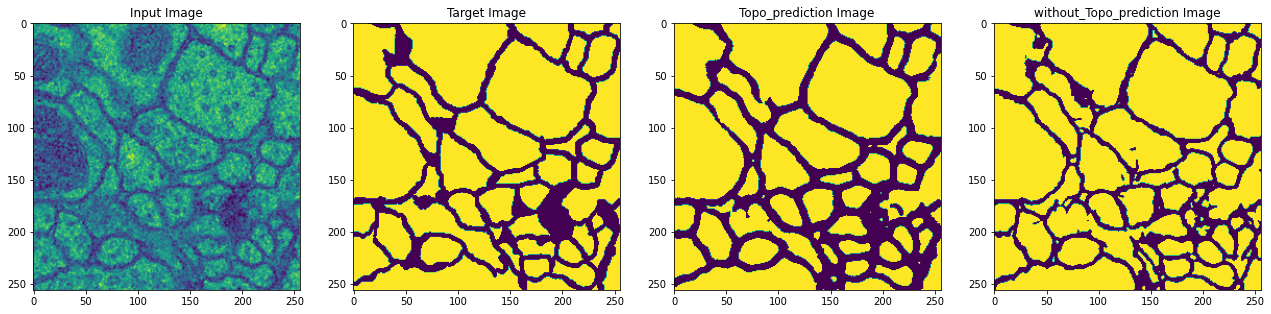

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,8))

plt.subplot(1,4,1)
plt.imshow(xin)
plt.title('Input Image')

plt.subplot(1,4,2)
plt.imshow(ytar)
plt.title('Target Image')

plt.subplot(1,4,3)
plt.imshow(youttopo)
plt.title('Topo_prediction Image')

plt.subplot(1,4,4)
plt.imshow(yout)
plt.title('without_Topo_prediction Image')